### Terminologies

- Taken from [AI Wiki](https://machine-learning.paperspace.com/wiki/weights-and-biases)
- [Fast.ai](https://course.fast.ai/Lessons/lesson1.html)
- AWS Research Credits
- [QBlocks](https://www.qblocks.cloud)
- [Vast.ai](https://vast.ai)


#### Testing Neurons
Neurons are the basic units of a neural network. In an ANN, **each neuron in a layer is connected to some or all of the neurons in the next layer**. When the inputs are transmitted between neurons, the weights are applied to the inputs along with the bias.


#### Weights
Weights control the signal (or the strength of the connection) between two neurons. In other words, *a weight decides how much influence the input will have on the output.*

#### Overfitting

Overfitting is a condition where the model produces good performance when it’s applied to training samples. However, it results poorly when it is applied to unknown samples in the testing process. In other words, the model does not generalize well 
for the whole case. Overfitting  is a fundamental problem in the field of supervised machine 
learning that may occur because the model tends to learn the entire training data including noise, 
rather than learn patterns or important hidden information in the data 

## Downloading Dataset

### Celebrity Deepfakes Dataset

Taken from `gdown` docs

> I set the permission 'Anyone with Link', but I still can't download.
>> Google restricts access to a file when the download is concentrated. If you can still access to the file from your browser, downloading cookies file might help. Follow these steps:
>>>1) Download `cookies.txt` using browser extensions like (Get cookies.txt LOCALLY)
>>>
>>>2) mv the `cookies.txt` to `~/.cache/gdown/cookies.txt`
>>>
>>>3) run download again. If you're using gdown>=5.0.0, it should be able to use the cookies same as your browser.

In [ ]:
# # !pip install gdown

# !cp /content/onedrive/cookies.txt  ~/.cache/gdown/cookies.txt

# !gdown 'https://drive.google.com/uc?id=1iLx76wsbi9itnkxSqz9BVBl4ZvnbIazj' --output /content/onedrive/dfd/datasets/CelebDF/v2.zip

# !unzip /content/onedrive/dfd/datasets/CelebDF/v2.zip -d /content/onedrive/dfd/datasets/CelebDF/

# !rm -rf /content/onedrive/dfd/datasets/CelebDF/v2.zip

## Model Training

### Imports

In [1]:
# File Processing
import os
import random
import shutil
from datetime import datetime

# Face extraction, cropping & display
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Model Training
from __future__ import print_function
from itertools import chain
import csv
import random
import os.path as osp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import ToPILImage
from PIL import Image
# from imgaug import augmenters as iaa
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
# from tqdm.notebook import tqdm
from tqdm import tqdm
import torchvision.transforms as transforms
import timm

# pip install scikit-learn
from sklearn.metrics import log_loss, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import dlib


In [2]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117 opencv-python numpy matplotlib Pillow imgaug scikit-image timm imutils 
# import torch
# pip install --upgrade ipywidgets
# torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.version.cuda)

cuda
12.1


### Preprocessing

##### Directories Creation

In [3]:
# define base directory
# real_videos = "E:/Merged_CelebDF_v2/Celeb-real"
# fake_videos = "E:/Merged_CelebDF_v2/Celeb-synthesis"

# base_dir = "E:/rclone"

real_videos = "Z:/celebdf_subset/Celeb-real"
fake_videos = "Z:/celebdf_subset/Celeb-fake"

base_dir = "Z:/rclone_subset"

test_split_dirs = ['train', 'validation', 'test']
dirs = []

for dir in test_split_dirs:
    for subdir in ['_real_videos', '_real_frames', '_real_faces', '_fake_videos', '_fake_frames', '_fake_faces']:
        path = os.path.join(base_dir, dir + subdir)
        os.makedirs(path, exist_ok=True)
        dirs.append(path)

# Destructure the dirs list
(train_real_videos, train_real_frames, train_real_faces, train_fake_videos, train_fake_frames, train_fake_faces,
 validation_real_videos, validation_real_frames, validation_real_faces, validation_fake_videos, validation_fake_frames, validation_fake_faces,
 test_real_videos, test_real_frames, test_real_faces, test_fake_videos, test_fake_frames, test_fake_faces) = dirs


##### Data Splitting

- Split the dataset into 70%, 15% & 15% for Training, Validation & Testing respectively.

    - train => 70% [70 fake% + 70 real%]
    - valid => 15% [15 fake% + 15 real%]
    - test => 15%  [15 fake% + 15 real%]

In [65]:
def move_videos(real_videos_dir, fake_videos_dir, train_real_dir, train_fake_dir, validation_real_dir, validation_fake_dir, test_real_dir, test_fake_dir):
    # Get the list of real and fake videos
    real_videos = os.listdir(real_videos_dir)
    fake_videos = os.listdir(fake_videos_dir)

    # Calculate the number of videos for each split
    train_count_real = int (0.7 * len(real_videos))
    train_count_fake =int (0.7 * len(fake_videos))
    validation_count_real = int (0.15 * len(real_videos))
    validation_count_fake = int (0.15 * len(fake_videos))

    # Shuffle the videos for unbiased results
    for i in range(15):
        random.shuffle(real_videos)
        random.shuffle(fake_videos)

    # Move real videos
    for video in real_videos[:train_count_real]:
        shutil.copy2(os.path.join(real_videos_dir, video), train_real_dir)
    for video in real_videos[train_count_real:train_count_real + validation_count_real]:
        shutil.copy2(os.path.join(real_videos_dir, video), validation_real_dir)
    for video in real_videos[train_count_real + validation_count_real:]:
        shutil.copy2(os.path.join(real_videos_dir, video), test_real_dir)

    # Move fake videos
    for video in fake_videos[:train_count_fake]:
        shutil.copy2(os.path.join(fake_videos_dir, video), train_fake_dir)
    for video in fake_videos[train_count_fake:train_count_fake + validation_count_fake]:
        shutil.copy2(os.path.join(fake_videos_dir, video), validation_fake_dir)
    for video in fake_videos[train_count_fake + validation_count_fake:]:
        shutil.copy2(os.path.join(fake_videos_dir, video), test_fake_dir)

# Move real and fake videos
move_videos(real_videos, fake_videos,
            train_real_videos, train_fake_videos,
            validation_real_videos, validation_fake_videos,
            test_real_videos, test_fake_videos)


#### Videos Preprocessing

- In this code block, videos will be converted into frames and for 16 random frames, face will be cropped and extracted from the frame and will be stored as the preprocessed step.
- The face will be augmented, normalized & resized.


##### Frames Extraction

In [66]:
# Function to extract frames from a video and select random frames
def extract_and_select_frames(video_path, output_dir, num_frames=16):
    video_cap = cv2.VideoCapture(video_path)
    total_frames = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Adjust num_frames if it's larger than the total number of frames
    num_frames = min(num_frames, total_frames)

    # Select random frames
    selected_frames = random.sample(range(0, total_frames), num_frames)

    # Read selected frames and save them
    for frame_number in selected_frames:
        video_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = video_cap.read()
        if not ret:
            continue
        cv2.imwrite(os.path.join(output_dir, f'{os.path.basename(video_path)}_frame_{frame_number}.jpg'), frame)
    video_cap.release()

# Process videos from the training set
for idx, video in enumerate(os.listdir(train_real_videos)):
    if video.endswith('.mp4'):
        print(f"Processing Training Real Video {idx + 1}/{len(os.listdir(train_real_videos))}")
        extract_and_select_frames(os.path.join(train_real_videos, video), train_real_frames, num_frames=32)

for idx, video in enumerate(os.listdir(train_fake_videos)):
    if video.endswith('.mp4'):
        print(f"Processing Training Fake Video {idx + 1}/{len(os.listdir(train_fake_videos))}")
        extract_and_select_frames(os.path.join(train_fake_videos, video), train_fake_frames)

# Process videos from the validation set
for idx, video in enumerate(os.listdir(validation_real_videos)):
    if video.endswith('.mp4'):
        print(f"Processing Validation Real Video {idx + 1}/{len(os.listdir(validation_real_videos))}")
        extract_and_select_frames(os.path.join(validation_real_videos, video), validation_real_frames, num_frames=32)

for idx, video in enumerate(os.listdir(validation_fake_videos)):
    if video.endswith('.mp4'):
        print(f"Processing Validation Fake Video {idx + 1}/{len(os.listdir(validation_fake_videos))}")
        extract_and_select_frames(os.path.join(validation_fake_videos, video), validation_fake_frames)

# Process videos from the testing set
for idx, video in enumerate(os.listdir(test_real_videos)):
    if video.endswith('.mp4'):
        print(f"Processing Testing Real Video {idx + 1}/{len(os.listdir(test_real_videos))}")
        extract_and_select_frames(os.path.join(test_real_videos, video), test_real_frames, num_frames=32)

for idx, video in enumerate(os.listdir(test_fake_videos)):
    if video.endswith('.mp4'):
        print(f"Processing Testing Fake Video {idx + 1}/{len(os.listdir(test_fake_videos))}")
        extract_and_select_frames(os.path.join(test_fake_videos, video), test_fake_frames)


Processing Training Real Video 1/35
Processing Training Real Video 2/35
Processing Training Real Video 3/35
Processing Training Real Video 4/35
Processing Training Real Video 5/35
Processing Training Real Video 6/35
Processing Training Real Video 7/35
Processing Training Real Video 8/35
Processing Training Real Video 9/35
Processing Training Real Video 10/35
Processing Training Real Video 11/35
Processing Training Real Video 12/35
Processing Training Real Video 13/35
Processing Training Real Video 14/35
Processing Training Real Video 15/35
Processing Training Real Video 16/35
Processing Training Real Video 17/35
Processing Training Real Video 18/35
Processing Training Real Video 19/35
Processing Training Real Video 20/35
Processing Training Real Video 21/35
Processing Training Real Video 22/35
Processing Training Real Video 23/35
Processing Training Real Video 24/35
Processing Training Real Video 25/35
Processing Training Real Video 26/35
Processing Training Real Video 27/35
Processing

##### Face Extraction

###### `dlib` Face Detection

In [68]:
def dlib_extract_faces(frame_dir, output_dir):
    for frame in os.listdir(frame_dir):
        if frame.endswith('.jpg'):
            # load the image
            frame_path = os.path.join(frame_dir, frame)
            frame = cv2.imread(frame_path)
            # Convert the image to grayscale (Dlib works with grayscale images)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            detector = dlib.get_frontal_face_detector()
            faces = detector(gray)
            for face in faces:
                x = face.left()
                y = face.top()
                w = face.right() - x
                h = face.bottom() - y
                face_img = frame[y:y+h, x:x+w]
                cv2.imwrite(os.path.join(output_dir, f'{os.path.basename(frame_path)}_face.jpg'), face_img)

# Extract faces from the frames
dlib_extract_faces(train_real_frames, train_real_faces)
dlib_extract_faces(train_fake_frames, train_fake_faces)
dlib_extract_faces(validation_real_frames, validation_real_faces)
dlib_extract_faces(validation_fake_frames, validation_fake_faces)
dlib_extract_faces(test_real_frames, test_real_faces)
dlib_extract_faces(test_fake_frames, test_fake_faces)

#### Model Training

In [4]:
# Results Reproducibility
seed = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

##### Data Unification & Labeling

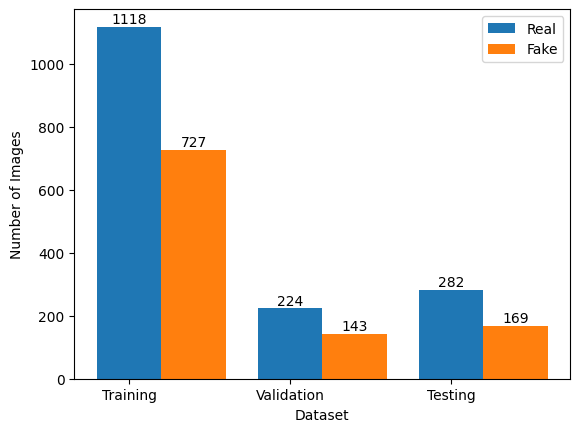

In [12]:
train_real_data = [os.path.join(train_real_faces, f) for f in os.listdir(train_real_faces)]
train_fake_data = [os.path.join(train_fake_faces, f) for f in os.listdir(train_fake_faces)]

validation_real_data = [os.path.join(validation_real_faces, f) for f in os.listdir(validation_real_faces)]
validation_fake_data = [os.path.join(validation_fake_faces, f) for f in os.listdir(validation_fake_faces)]

test_real_data = [os.path.join(test_real_faces, f) for f in os.listdir(test_real_faces)]
test_fake_data = [os.path.join(test_fake_faces, f) for f in os.listdir(test_fake_faces)]

# Create lists for real and fake images
train_data = [len(train_real_data), len(train_fake_data)]
validation_data = [len(validation_real_data), len(validation_fake_data)]
test_data = [len(test_real_data), len(test_fake_data)]

# Combine the data into a single list
data = [train_data, validation_data, test_data]

# Create labels for the plot
labels = ['Training', 'Validation', 'Testing']

# Create a bar chart
x = range(len(labels))
width = 0.4
plt.bar(x, [d[0] for d in data], width, label='Real')
plt.bar([x_i + width for x_i in x], [d[1] for d in data], width, label='Fake')

# Add labels and legend
plt.xticks(x, labels)
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.legend()

# Add the length of real and fake images on top of each bar
for i, d in enumerate(data):
    plt.text(i, d[0] + 1, f'{d[0]}', ha='center', va='bottom')
    plt.text(i + width, d[1] + 1, f'{d[1]}', ha='center', va='bottom')

# Show the plot
plt.show()

##### View Training Data

In [13]:
# Create lists for real and fake images
train_images = train_real_data + train_fake_data
validation_images = validation_real_data + validation_fake_data
test_images = test_real_data + test_fake_data

for i in range(15):
  np.random.shuffle(train_images)
  np.random.shuffle(validation_images)
  np.random.shuffle(test_images)

# print(train_images[:10])
# Extracting labels from directory paths
labels = []
for path in train_images:
    if 'real' in path:
        labels.append('real')
    else:
        labels.append('fake')

[ 104 1246 1306 1412  372  129 1428  220 1197]


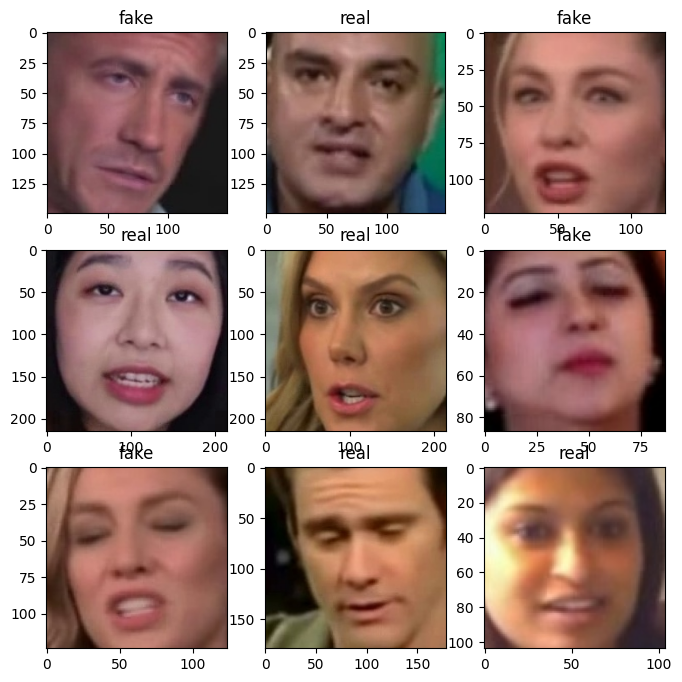

In [14]:
random_idx = np.random.randint(1, len(train_images), size=9)
print(random_idx)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for idx, ax in enumerate(axes.ravel()):
    # img = Image.open(all_training_images[idx])
    img = Image.open(train_images[random_idx[idx]])
    ax.set_title(labels[idx])
    ax.imshow(img)

##### Transform Compositions

- The code defines three separate transform compositions (`train_transforms`, `val_transforms`, and `test_transforms`) using PyTorch's Compose transform. Each composition includes:

    - Resizing the image to a fixed size of 224x224.
    - Randomly flipping the image horizontally with a probability of 0.5.
    - Converting the image to a PyTorch tensor.
      - Tensors are multi-dimensional arrays, similar to NumPy's ndarrays, but with the added capability of being able to run on GPUs.
    - Normalizing the tensor using the Normalize transform.
      - Normalization is a process of scaling the values of a tensor to a common range, typically between 0 and 1.


In [15]:
# from torchvision import datasets, transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [16]:
class DeepFakeSet(Dataset):
    def __init__(self, file_list, transform=None):

        self.file_list = file_list
        self.transform = transform
        self.to_img = ToPILImage()
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("Z:/Cuda+Torch+MKL-libs/shape_predictor_81_face_landmarks.dat")

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = 1 if 'real' in img_path else 0
        return img_transformed, label

In [17]:
# for performing augmentation on the images, uncomment the line below
# train_data = DeepFakeSet(all_training_images, transform=transforms_imgaug)

train_data = DeepFakeSet(train_images, transform=train_transforms)
valid_data = DeepFakeSet(validation_images, transform=val_transforms)

batch_size = 16

# from torch.utils.data import DataLoader, Dataset
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)

print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

1845 116
367 23


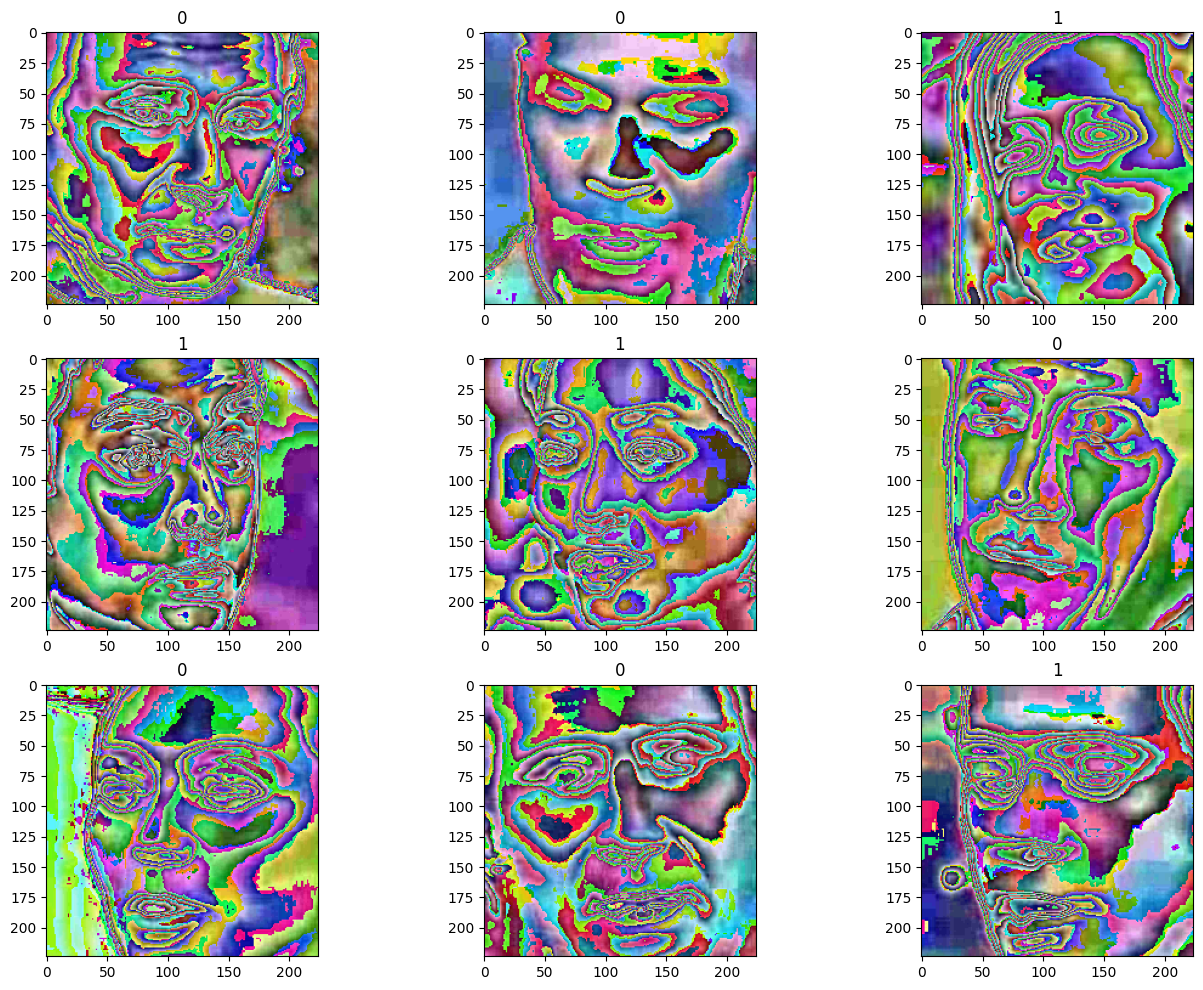

In [89]:
to_img = ToPILImage()

random_idx = np.random.randint(0, len(train_data) - 1, size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = to_img(train_data[random_idx[idx]][0])
    ax.set_title(train_data[random_idx[idx]][1])
    ax.imshow(img)


In [90]:
models = ['swin_base_patch4_window7_224']

augs = ['No_Augmentations', 'Random_Cut_Out_Augs', 'Face_Cut_Out_Augs']
datasets = ['FakeAVCeleb', 'FaceForensics', 'DFDC', 'CelebDFV2']

In [91]:
# No augs
for model in models:

    print("==========================================================================")
    print("==========================================================================")
    # print("Training " + model + " on " + datasets[3])
    net = timm.create_model(model, pretrained=True, num_classes=2).to(device)
    epochs = 10
    lr = 3e-3
    # gamma = 0.7

    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_accuracies = []
    train_losses = []

    validation_accuracies = []
    validation_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)

            optimizer.zero_grad()

            output = net(data)
            loss = criterion(output, label)

            loss.backward()
            optimizer.step()
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_accuracies.append(epoch_accuracy.detach())
        train_losses.append(epoch_loss.detach())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in tqdm(valid_loader):
                data = data.to(device)
                label = label.to(device)
                # print(data.shape)
                val_output = net(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

            validation_accuracies.append(epoch_val_accuracy.detach())
            validation_losses.append(epoch_val_loss.detach())
        
        # folder_path = (base_dir + "/weights/supervised_models/" + model + "/" + augs[0] + '/' + datasets[3] + '/')
        folder_path = (base_dir + "/weights/supervised_models/swin_base_patch4_window7_224/no_augmentation/celebdf_v2/")
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        if epoch == 0:
            PATH = (folder_path + str(epoch+1) + "_epochs.pth")
            torch.save(net.state_dict(), PATH)
        elif epoch > 0:
            if validation_losses[epoch-1] < validation_losses[epoch]:
                pass
            else:
                old_weights_file = (folder_path + str(epoch) + "_epochs.pth")
                if os.path.isfile(old_weights_file):
                    os.remove(old_weights_file)
                else:
                    pass
                # Save the state of the model to file
                PATH = (folder_path + str(epoch+1) + "_epochs.pth")
                torch.save(net.state_dict(), PATH)
        print(
            f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        torch.cuda.empty_cache()


    with open(folder_path + 'results.csv', 'w') as csvfile:
        fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

        writer.writeheader()
        for i in range(len(validation_accuracies)):
            writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})

    print("==========================================================================")
    print("==========================================================================")


100%|██████████| 23/23 [00:06<00:00,  3.32it/s]


Epoch : 1 - train_loss : 0.4391 - train_acc: 0.7953 - val_loss : 0.7505 - val_acc: 0.6051



100%|██████████| 23/23 [00:07<00:00,  3.08it/s]


Epoch : 2 - train_loss : 0.1877 - train_acc: 0.9343 - val_loss : 0.8425 - val_acc: 0.6969



100%|██████████| 23/23 [00:06<00:00,  3.39it/s]


Epoch : 3 - train_loss : 0.0792 - train_acc: 0.9784 - val_loss : 0.9215 - val_acc: 0.7275



100%|██████████| 23/23 [00:06<00:00,  3.51it/s]


Epoch : 4 - train_loss : 0.0415 - train_acc: 0.9914 - val_loss : 0.9704 - val_acc: 0.7415



100%|██████████| 23/23 [00:06<00:00,  3.38it/s]


Epoch : 5 - train_loss : 0.0151 - train_acc: 0.9973 - val_loss : 1.0399 - val_acc: 0.7596



100%|██████████| 23/23 [00:06<00:00,  3.47it/s]


Epoch : 6 - train_loss : 0.0118 - train_acc: 0.9984 - val_loss : 1.1679 - val_acc: 0.7736



100%|██████████| 23/23 [00:06<00:00,  3.47it/s]


Epoch : 7 - train_loss : 0.0050 - train_acc: 0.9995 - val_loss : 1.1214 - val_acc: 0.7792



100%|██████████| 23/23 [00:06<00:00,  3.38it/s]


Epoch : 8 - train_loss : 0.0171 - train_acc: 0.9946 - val_loss : 1.0700 - val_acc: 0.7359



100%|██████████| 23/23 [00:06<00:00,  3.59it/s]


Epoch : 9 - train_loss : 0.0944 - train_acc: 0.9628 - val_loss : 1.0473 - val_acc: 0.7714



100%|██████████| 23/23 [00:06<00:00,  3.40it/s]

Epoch : 10 - train_loss : 0.0113 - train_acc: 0.9989 - val_loss : 1.2013 - val_acc: 0.7525



## Model Evaluation

In [18]:
# for i in range(5):
#     np.random.shuffle(test_images)

# frame = pd.DataFrame(test_images, columns=['path'])
# # Add the new 'label' column
# frame['label'] = frame['path'].apply(lambda x: 0 if 'real' in x else 1)
# print(frame)

# frame.to_csv('celebdf_v2_test_images.csv', index=False, sep=',', header=True, encoding='utf-8')


# celebdf_paths_df = pd.read_csv("E:/Deepscan/reduced_celebdf_v2_test_images.csv")
celebdf_test_csv = pd.read_csv("Z:/Deepscan/reduced_celebdf_v2_test_images.csv")
celebdf_test_csv = pd.read_csv("Z:/Deepscan/celebdf_v2_test_images.csv")

# test_set_paths_dictionary = {
#                             'CelebDFV2': [celebdf_paths_df['path'], celebdf_paths_df['label']],
#                             }

In [23]:
# PATH = "E:/rclone/weights/supervised_models/swin_base_patch4_window7_224/no_augmentation/celebdf_v2"
PATH = "Z:/rclone/weights/supervised_models/swin_base_patch4_window7_224/no_augmentation/celebdf_v2/"
model_name = "swin_base_patch4_window7_224"
dataset = "CelebDFV2"

for file in os.listdir(PATH):
    if file.endswith(".pth"):
        model_path = os.path.join(PATH, file)
        print(model_path)
        # model = timm.create_model(model_name, pretrained=True, num_classes=2).to(device)
        # model.load_state_dict(torch.load(model_path), strict=True)
        # model.to(device)
        # model.eval()
        # Load the trained model
        model_path = "Z:/rclone_subset/weights/supervised_models/swin_base_patch4_window7_224/no_augmentation/celebdf_v2/9_epochs.pth"
        model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=2).to(device)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        print("loaded " + model_name + " weights!")

        print('Evaluating ' + model_name + ' trained on ' + dataset)
        # Create the save path
        save_path = os.path.join('Z:/Deepscan/evaluation', f"{model_name}_trained_on_{dataset}_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
        torch.manual_seed(17)
        Evaluate(model, celebdf_test_csv, dataset, save_path)

        print('====================================================================================================')

Z:/rclone/weights/supervised_models/swin_base_patch4_window7_224/no_augmentation/celebdf_v2/9_epochs.pth
loaded swin_base_patch4_window7_224 weights!
Evaluating swin_base_patch4_window7_224 trained on CelebDFV2


In [22]:
def get_scores(predictions):
    print(predictions)
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for key, value in predictions.items():
        predicted_probs.append(value[0])
        true_labels.append(value[2])
        predicted_labels.append(value[1])

    logloss = log_loss(true_labels, predicted_probs)
    auc = roc_auc_score(true_labels, predicted_probs)
    f1 = f1_score(true_labels, predicted_labels)
    
    print(f'Logloss is: {logloss} & AUC Score is: {auc} & F1 Score is: {f1}')
    # return
    return logloss, auc, f1

def Evaluate(model, faces_path_dict, dataset, save_path):
    
    # print(faces_path_dict)
    imgs_path = faces_path_dict['path']
    imgs_label = faces_path_dict['label']

    # print(imgs_path, imgs_label)
    labels_map = ['fake', 'real']
    predictions = {}

    faces = []
    for img in faces_path_dict['path']:
        original_label = 0 if 'real' in img else 1
        if img.endswith('.jpg'):
            face = cv2.imread(img)
            faces.append(face)

        # preprocess the faces
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

        # Run the model on the faces
        outputs = []
        model.eval()

        with torch.no_grad():
            for face in faces:
                face_pil = Image.fromarray(face)
                # print(face_pil)
                face_tensor = transform(face_pil).unsqueeze(0).to(device)
                outputs = model(face_tensor)
                # print(labels_map[torch.argmax(output.cpu()).item()])
                # print(f'image_path: {img}')
                # print(f'variable output is: {output}')
                # print(f'variable output on cpu: {output.cpu()} & the device type is: {output.cpu().device}')
                # outputs.append(torch.argmax(output.cpu()).item())
                    # outputs = model(face_tensor)
                    # probability_fake = torch.softmax(outputs, 1)[:, 1].item()
                    # probability_real = torch.softmax(outputs, 1)[:, 0].item()

                    # if labels_map[torch.argmax(outputs).item()] == 'fake':
                    #     predictions[img] = [probability_fake, 0, original_label]
                    # else:
                    #     predictions[img] = [probability_real, 1, original_label]
                # print(output.cpu().item())
                # outputs.append(torch.argma)

        # print(outputs)
        # for idx, prediction in enumerate(outputs):
        #     # print(idx, prediction)
        #     # continue
        #     if prediction == 1:
        #         print(f'Face {faces[idx]}: Deepfake Detectd!')
        #     else:
        #         print(f'Face {faces[idx]}: Real Video!')

        # if labels_map[prediction] == 'fake':
        #     predictions[img] = [1 - prediction, 0, original_label]
        # else:
        #     predictions[img] = [prediction, 1, original_label]

        probability_fake = torch.softmax(outputs, 1)[:, 1].item()
        probability_real = torch.softmax(outputs, 1)[:, 0].item()

        if labels_map[torch.argmax(outputs).item()] == 'fake':
            predictions[img] = [probability_fake, 1, original_label]
        else:
            predictions[img] = [probability_real, 0, original_label]

    # get_scores(predictions)
    # return
    with open(save_path + '.csv', 'w') as csvfile:
        fieldnames = ['ImagePath', 'ProbabilityScore', 'PredictedLabel', 'OriginalLabel']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

        writer.writeheader()
        # print(predictions)
        for i in range(len(predictions)):
            print
            img = list(predictions)[i]
            writer.writerow({'ImagePath': list(predictions)[i], 'ProbabilityScore': predictions[img][0], 'PredictedLabel': predictions[img][1], 'OriginalLabel': predictions[img][2]})

    logloss, auc, f1 = get_scores(predictions)
    fieldnames = ['LogLoss','AUC','F1-Score']
    with open(save_path + '.csv', 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)
        writer.writeheader()
        writer.writerow({'LogLoss': logloss, 'AUC': auc, 'F1-Score': f1})
    torch.cuda.empty_cache()


    return






    imgs_path = vids_path_dict[dataset][0]
    true_labels = vids_path_dict[dataset][1]
    count = 0
    labels_map = ["fake", "real"]
    predictions = {}
    # probs = {}
    for img in imgs_path:
        print(img)
        # continue
        # real = 1, fake = 0
        originallabel = 1 if 'real' in img else 0
        # print(f'{img} - {originallabel}')

        count+=1
        # print(count)
        image = img.replace('\\','/')
        img = Image.open(image)
        tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        img = tfms(img)
        with torch.no_grad():
            outputs = model(img.unsqueeze(0).to(device))
            class_index = outputs.argmax()

        print(outputs)
        print(class_index)
        
        predicted_prob = []
        predicted_label = None
        for idx in torch.topk(outputs[0], k=1).indices.tolist():
            prob = torch.softmax(outputs[0], 0)[idx].item()
            # print(f'probability of {img} - {prob}')
            print(f'---{idx}---')

        print(f'{idx} - {labels_map[idx]}')
        # continue

        if labels_map[idx] == 'fake':
            predicted_prob = 1 - prob
            predictions[image] = [predicted_prob, 0, originallabel]
        else:
            predicted_prob = prob
            print(predicted_prob)
            predictions[image] = [predicted_prob, 1, originallabel]
        print('--------------')
        print(predictions)

    with open(save_path + '.csv', 'w') as csvfile:
        fieldnames = ['ImagePath', 'ProbabilityScore', 'PredictedLabel', 'OriginalLabel']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

        writer.writeheader()
        for i in range(len(predictions)):
            img = list(predictions)[i]
            writer.writerow({'ImagePath': list(predictions)[i], 'ProbabilityScore': predictions[img][0], 'PredictedLabel': predictions[img][1], 'OriginalLabel': predictions[img][2]})

    logloss, auc, f1 = get_scores(predictions)
    fieldnames = ['LogLoss','AUC','F1-Score']
    with open(save_path + '.csv', 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)
        writer.writeheader()
        writer.writerow({'LogLoss': logloss, 'AUC': auc, 'F1-Score': f1})
    torch.cuda.empty_cache()
    #     break

## Prediction

In [78]:
import torch
import torchvision.transforms as transforms
import cv2
import timm
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda'

# Load the trained model
model_path = "Z:/rclone_subset/weights/supervised_models/swin_base_patch4_window7_224/no_augmentation/celebdf_v2/9_epochs.pth"
net = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=2).to(device)
net.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

<All keys matched successfully>

Face [[[131 138 147]
  [122 129 138]
  [113 120 129]
  ...
  [ 61  60  69]
  [ 61  60  69]
  [ 59  61  69]]

 [[132 139 148]
  [123 130 139]
  [113 120 129]
  ...
  [ 61  60  69]
  [ 61  60  69]
  [ 59  61  69]]

 [[132 139 148]
  [123 130 139]
  [114 121 130]
  ...
  [ 61  60  69]
  [ 61  60  69]
  [ 59  61  69]]

 ...

 [[130 140 157]
  [123 133 150]
  [111 121 138]
  ...
  [ 46  55  69]
  [ 47  56  70]
  [ 45  53  70]]

 [[130 140 157]
  [123 133 150]
  [111 121 138]
  ...
  [ 47  54  69]
  [ 47  56  70]
  [ 45  53  70]]

 [[130 140 157]
  [123 133 150]
  [111 121 138]
  ...
  [ 48  53  68]
  [ 45  52  67]
  [ 45  53  70]]]: Real video!
Face [[[151 151 163]
  [151 151 163]
  [151 151 163]
  ...
  [155 152 167]
  [153 150 166]
  [153 150 166]]

 [[155 155 167]
  [155 155 167]
  [155 155 167]
  ...
  [158 155 170]
  [155 152 168]
  [155 152 168]]

 [[158 158 170]
  [158 158 170]
  [159 159 171]
  ...
  [162 158 170]
  [160 155 170]
  [160 155 170]]

 ...

 [[ 19  20  40]
  [ 16  17  3

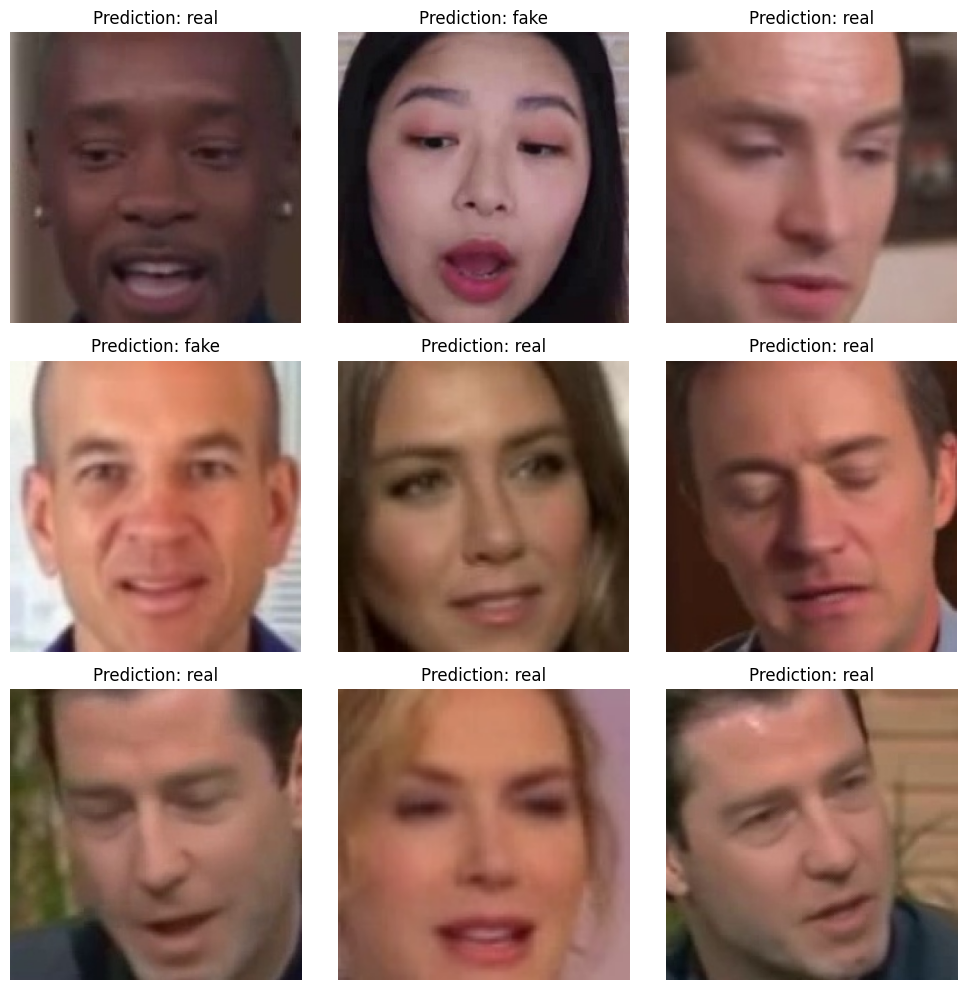

In [79]:
celebdf_test_csv = pd.read_csv("Z:/Deepscan/reduced_celebdf_v2_test_images.csv")

# Load the extracted faces
faces = []
faces_graph = []  # To keep track of face file names for plotting
for file in celebdf_test_csv['path']:
    if file.endswith('.jpg'):
        face = cv2.imread(file)
        faces.append(face)
        faces_graph.append(file)

# Preprocess the faces
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Run the model on the faces
outputs = []
-.eval()  # Set model to evaluation mode
with torch.no_grad():
    for face in faces:
        face_pil = Image.fromarray(face)
        face_tensor = transform(face_pil).unsqueeze(0).to(device)  # Add batch dimension and move to GPU
        output = net(face_tensor)
        outputs.append(torch.argmax(output.cpu()).item())  # Move output to CPU and extract index

# Thresholding and classification
for idx, prediction in enumerate(outputs):
    if prediction == 1:
        print(f"Face {faces[idx]}: Deepfake detected!")
    else:
        print(f"Face {faces[idx]}: Real video!")

# Create a matplotlib plot with the image frames embedded and the labels as the prediction
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(os.path.join(faces_dir, faces_graph[idx]))
    ax.set_title('Prediction: ' + ('fake' if outputs[idx] == 1 else 'real'))
    ax.imshow(img)
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()
